## Clustering Methods in Python
#### Authors: Lucas Joseph, Nikhil Kuniyil, Johnson Sy Leung, Kasturi Sharma, Daniel Yan

This vignette will compare three different clustering methods implemented in python in order to assess their performance. This will be demonstrated using a data set that deals with user behavior depending on what kind of phone they have.

### Objective:
To explore the process of clustering through a dataset and explore how k-means, spectral, and agglomerative clustering algorithms perform on the dataset. 

___
## Concept Overview:
**Clustering** is a type of unsupervised machine learning that is used to group similar data points into unique clusters. Although the way in which similarity is determined varies between the different clustering methods, the end goal is still sorting data points in a way thhat maximizes similarity within a cluster while minimizing similarity between clusters.

Clustering can be used in many contexts as the unsupervised nature of the method means that it is very flexible. Some of the possible uses of clustering methods include fraud detection, crime analysis, and customer segmentation.

We will be comparing three different clustering methods today: k means, agglomerative hierarchical, and spectral.

___
### Data Description:
The dataset represents user behavior data collected from various mobile devices and includes 12 attributes for 188 users. Key attributes include Device Model, Operating System, and demographic information such as Age and Gender, alongside numerical metrics that measure daily device usage. These numerical metrics include App Usage Time (min/day), Screen On Time (hours/day), Battery Drain (mAh/day), Number of Apps Installed, and Data Usage (MB/day). Additionally, each user is assigned a User Behavior Class, which categorizes their usage patterns into five distinct classes.

The dataset provides a mix of categorical and numerical features, making it suitable for various clustering and classification analyses. The categorical features, such as Device Model and Operating System, allow for insights into behavioral differences across devices and platforms, while the numerical features provide detailed quantitative data on user interaction with their devices. With its diverse set of attributes, this dataset offers opportunities to explore user segmentation, predict user behavior patterns, and analyze correlations between usage habits and demographics.

Before implementing any model, we used the script `preprocessing.py` to one-hot encode the categorical categories and drop the identifying columns such as `User ID` and `User Behavior Class`.

___
#### Exploratory Data Analysis

Looking at the data, the first thing we will examine is the distribution of our usage metrics (screen time, battery drain, etc.). Looking at graphs for the distribution of each statistic, we note that all device models have extremely similar distributions for each metric. 

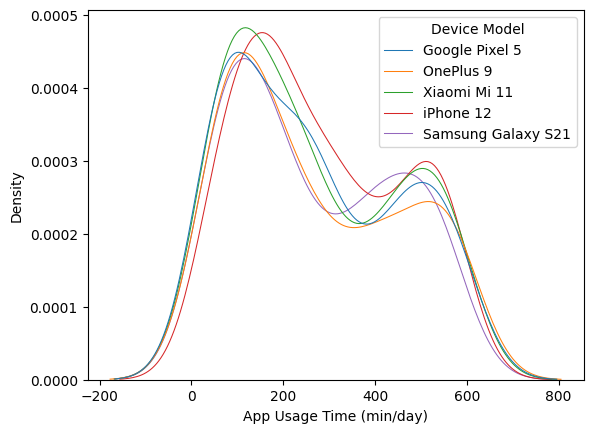

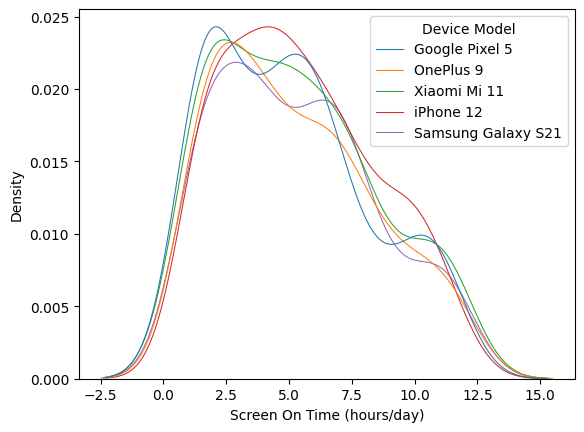

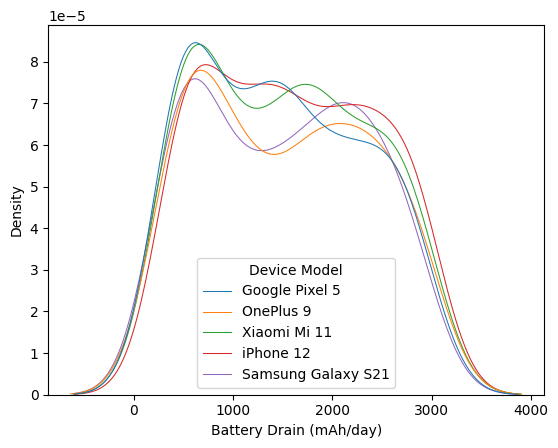

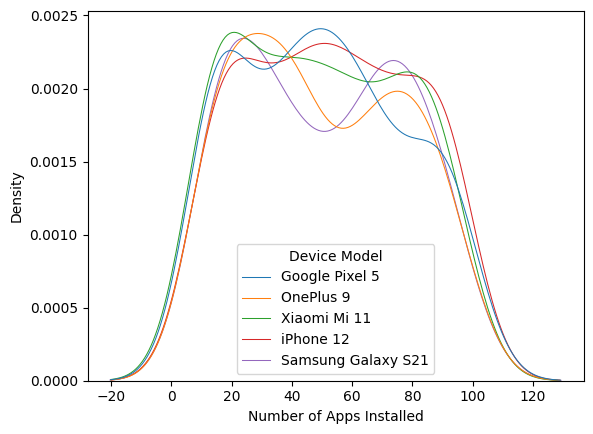

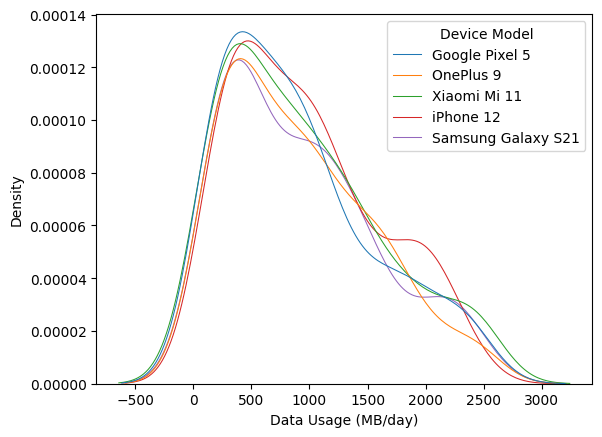

In [1]:
import sys
sys.path.append('../scripts')
from eda import *

density_plots()

This is important to note as with just this information it would be nearly impossible to be able to discern any meaningful trends without the use of clustering. Additionally, upon examining a correlation matrix between all the variables, we can also note the extremely high autocorrelation between each of these usage statistics. This is in contrast to the general lack of correlation whatsoever between device model and usage statistics which explains why the distributions are extremely similar. We also note the high correlation between iOS and the iPhone 12 which makes sense as only the iPhone 12 in this dataset uses the iOS operating system. 

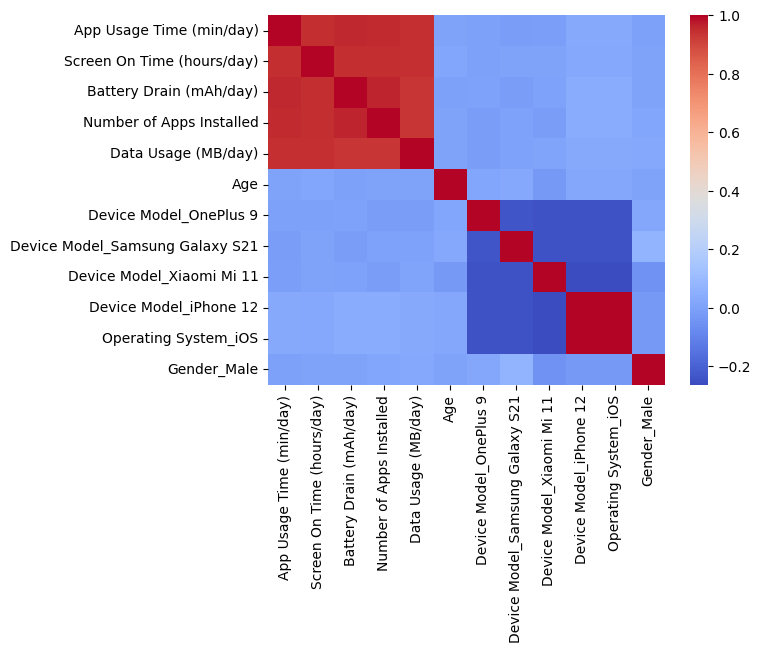

In [2]:
corr_plot()

___
## Clustering Implementation
### K-Means Clustering:
K-Means clustering is a partitioning clustering algorithm that in principle is similar to the supervised machine learning method K-Nearest Neighbors. 

Following the classic k-means algorithm or "naive k-means", the method involves randomly selecting K points to serve as cluster centers or *centroids* and then assigning each point in the dataset to its nearest cluster using Euclidiean distance. The location of centroids are then recalculated to be the mean of all items within the cluster, and each point will be reassigned to its nearest cluster. The process of recalculating the centroid location and assigning clusters is repeated until cluster assignments stop significantly changing.

Though there are many different means of choosing initial centroid locations, we chose to use **k-means++ initialization**. This method involves selecting a random centroid, computing the distance between each point and the centroid, then selecting the location for the next centroid from datapoint with a probability proportional to the distance squared from the closest existing centroid. This is repeated k times and ensures that the centroids are less likely to be close together.

The naive k-means algorithm has faster alternatives and is not guaranteed to find the optimum clusters.

We begin the implementation by importing the transformed dataset, scaling all variables, and then performing principle components analysis to reduce the dimensionality of our dataset.

In [1]:
# Import relevant packages
from sklearn.cluster import KMeans # type: ignore
from sklearn.metrics import silhouette_score # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt

# Read in data
df_transformed = pd.read_csv('../data/transformed_user_behavior_dataset.csv')
df = pd.read_csv('../data/user_behavior_dataset.csv')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

# PCA 
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_scaled)
print(pca_2.explained_variance_ratio_) # Explain this stat

[0.39939424 0.18529069]


We also find that by PCA to 2 components, components PC1 and PC2 account for roughly 39.94% and 18.53% of the variance in the data respectively.

We then must decide how many clusters are appropriate for our data. To do this, we employ *the elbow method* and examine the *silhouette scores of the k-means model for each number of clusters. 

- **The elbow method** finds the optimal number of clusters by running k-means clustering for different values of k, then selecting for a number of clusters where the sum of squared distances between points and their cluster(within cluster sum of squares/WCSS) does not drop significantly with the addition of more clusters.
- A **silhouette score** is a metric which represents how similar points within a cluster are, and how far away they are from other clusters. We will plot the average silhouette score across all clusters for different values of K to inform our choice of K.

Here we initialize 10 different K-means models using k-means++ initialization and evaluate the resulting WCSS and silhouette scores.

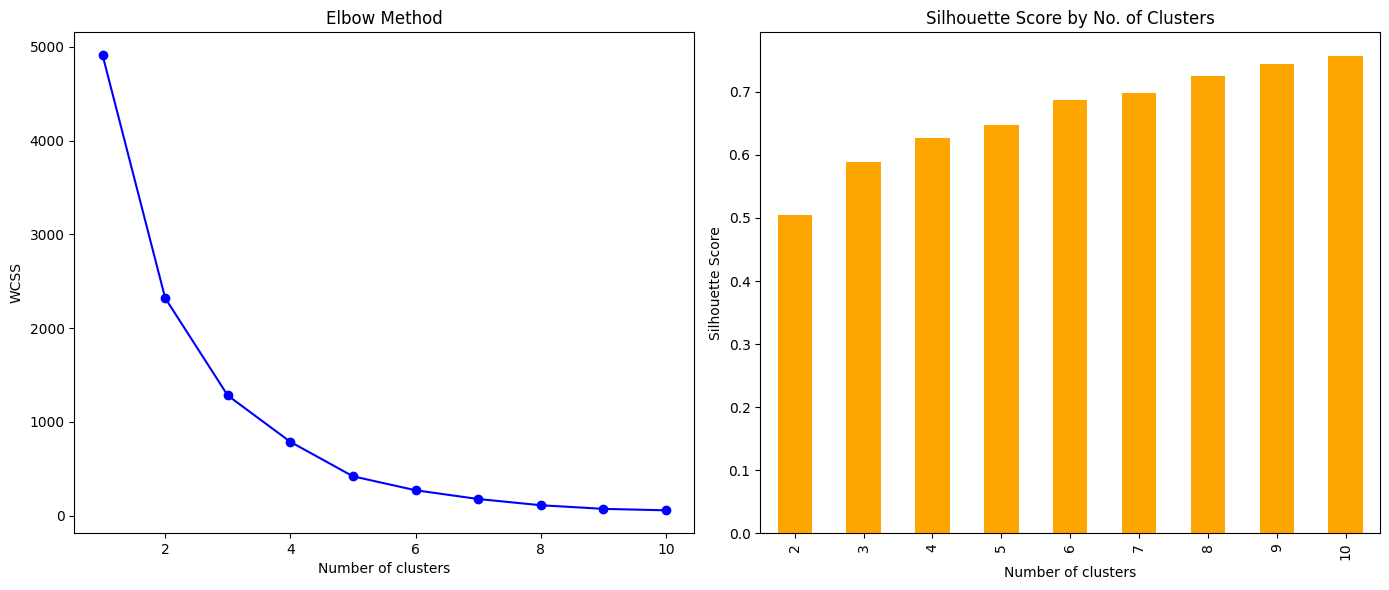

In [2]:
# Use elbow method to find optimal number of clusters
wcss = [] # average within cluster sum of squares
silhouette_scores = []
models = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0) # n_init: Number of times the k-means algorithm is run with different centroid seeds
    kmeans.fit(pca_2_result)
    wcss.append(kmeans.inertia_) # inertial is the wcss for a given number of clusters
    models.append(kmeans)  

    if i > 1:
        labels_i = kmeans.labels_
        silhouette_avg_i = silhouette_score(pca_2_result, labels_i)
        silhouette_scores.append(silhouette_avg_i)

# Display plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Elbow Plot
axs[0].plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')

# Silhouette Plot
silhouette_df = pd.DataFrame({"silhouette_score": silhouette_scores, "no_clusters": range(2, 11)})
silhouette_df.plot(x='no_clusters', y='silhouette_score', kind='bar', ax=axs[1], legend=False, color='orange')
axs[1].set_title('Silhouette Score by No. of Clusters')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')

# Save fig
plt.tight_layout()
plt.savefig('../img/fig-combined_elbow_silhouette.png')
plt.show()

The left figure shows that the within cluster sum of squares begins stop decreasing dramatically at around 5 or 6 clusters. We also see that the right figure shows that 6 clusters leads to a silhouette score of roughly .68. We'll choose the k-means model with 6 clusters to evaluate. 

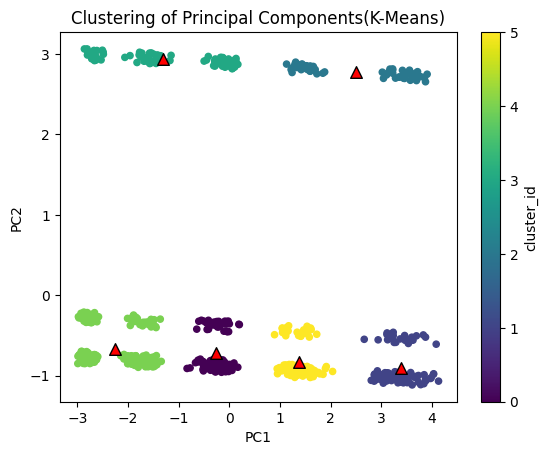

Silhouette score for K-means model: 0.6869174226355345
Davies Bouldin Score for Spectral Model: 0.42362465701577917
Calinski Harabasz Score for Spectral Model: 2375.873529468813


In [3]:
# Applying K-Means++ initialization
n_clusters = 6

kmeans = models[n_clusters - 1]
labels = kmeans.labels_

# Visualization using PCA 
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids)
centroids_df = centroids_df.rename(columns={0: "PC1", 1:"PC2"})  

viz = pd.DataFrame(pca_2_result)
viz['cluster_id'] = labels
viz = viz.rename(columns={0: "PC1", 1:"PC2"})    
viz.plot.scatter('PC1', 'PC2', c=2, colormap='viridis')

plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=70, linewidths=1,
                color='red', edgecolors="black")
plt.title('Clustering of Principal Components(K-Means)')
plt.savefig('../img/fig-k-means-clusters-PCA.png')
plt.show()

# Metrics 

df_km = df_transformed
df_km['Cluster'] = labels

silhouette_avg_km = silhouette_score(pca_2_result, labels)
print(f"Silhouette score for K-means model: {silhouette_avg_km}")

db_index = davies_bouldin_score(pca_2_result, labels)
print(f"Davies Bouldin Score for K-means Model: {db_index}")

ch_index = calinski_harabasz_score(pca_2_result, labels)
print(f"Calinski Harabasz Score for K-means Model: {ch_index}")

Although k-means clustering provides a powerful framework for conducting cluster analysis, it has a few major drawbacks. First, as cluster centroids are randomly selected, different initializations can lead to different final cluster assignments and can converge to a local minimum instead of a global minimum. The algorithm also assumes that clusters are spherical in space with similar sizes, which may not be the case in more complex datasets.

___
### Agglomerative Hierarchical Clustering:
Agglomerative clustering is a type of hierarchical clustering which aims to build a hierarchy of clusters in a "bottom-up" fashion. Each data point is initially labeled as its own separate clusters. Each datapoint has its distance between all other points calculated, and then merges with the closest point to form a new cluster. This process repeats until all clusters have merged into one. 

Agglomerative clustering can use different distance metrics as well as linkage criterias to define similarity between clusters allowing for more flexibility and powerful when compared to K-means clustering. 

One of the main drawbacks of agglomerative clustering is that it can be very computationally expensive due to each observation starting as its own cluster.

Below we construct a dendrogram for our data after scaling and performing PCA. A dendrogram is the resulting tree of clusters created after linking points. We use Euclidian distance as the distance metric, and the median linkage method, which sets the new centroid after joining clusters to be the median point between the two clusters. 

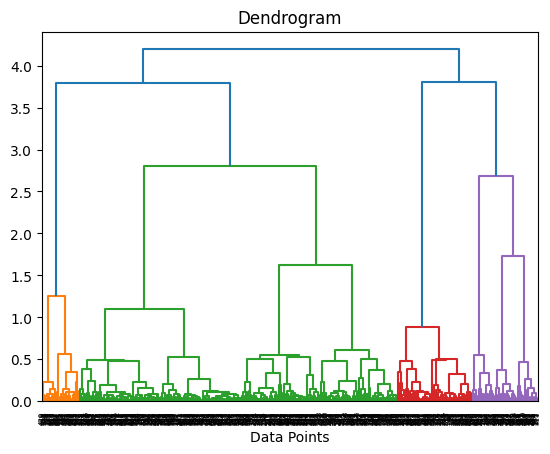

In [161]:
# agglomerative script
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc

# Read in data
df_transformed = pd.read_csv('../data/transformed_user_behavior_dataset.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

# Generate dendrogram
dend = shc.dendrogram(shc.linkage(pca_2_result, method='median')) # why use ward? 
plt.title("Dendrogram")
plt.xlabel("Data Points")
plt.savefig("../img/fig-dendrogram.png")
plt.show()

After looking at the dendrogram and generating sample models, we've decided to use 6 clusters for the model.

We can now visualize the clusters:

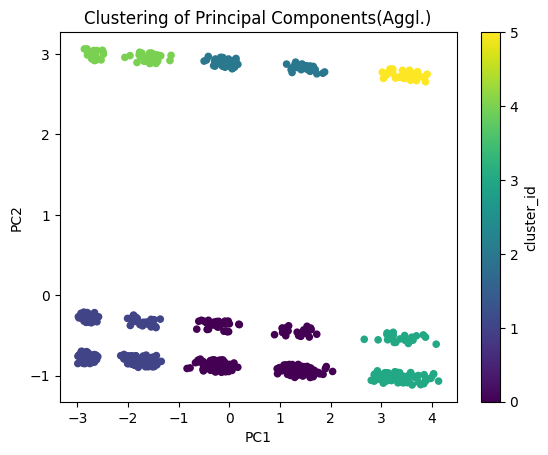

Silhouette score for Agglomerative Hierarchical Model: 0.658934359393889
Davies Bouldin Score for Spectral Model: 0.466123263594241
Calinski Harabasz Score for Spectral Model: 1945.7371737775018


In [162]:
# Build Agglomerative model and visualize
n_clusters = 6 
agglom = AgglomerativeClustering(n_clusters=n_clusters).fit(pca_2_result) 
labels = agglom.labels_

# centroids = agglom.cluster_centers_
# centroids_2 = pca_2.fit_transform(centroids)

viz = pd.DataFrame(pca_2_result)
viz['cluster_id'] = labels
viz = viz.rename(columns={0: "PC1", 1:"PC2"})

viz.plot.scatter('PC1', 'PC2', c=2, colormap='viridis')

#plt.scatter(centroids_2[:, 0], centroids_2[:, 1], marker='X', s=200, linewidths=1.5,
#                color='red', edgecolors="black")
plt.title('Clustering of Principal Components(Aggl.)')
plt.savefig('../img/fig-agglom-PCA.png')
plt.show()

df_agg = df_transformed
df_agg['Cluster'] = labels

silhouette_avg_agg = silhouette_score(pca_2_result, labels)
print(f"Silhouette score for Agglomerative Hierarchical Model: {silhouette_avg_agg}")

db_index = davies_bouldin_score(pca_2_result, labels)
print(f"Davies Bouldin Score for Agglomerative Hierarchical: {db_index}")

ch_index = calinski_harabasz_score(pca_2_result, labels)
print(f"Calinski Harabasz Score for Agglomerative Hierarchical: {ch_index}")

___
### Spectral Clustering:
Spectral clustering is an advanced clustering technique that leverages the eigenvalues and eigenvectors of a similarity matrix to group data points based on their relationships, making it particularly effective for non-convex or complex datasets. 

In the context of our dataset, spectral clustering can be used to group users into behavior-based segments by considering both categorical features, such as Device Model and Operating System, and numerical features like App Usage Time and Screen On Time. By constructing a similarity matrix based on these features, spectral clustering can uncover intricate patterns in user behavior, identifying clusters that may not be immediately apparent with simpler methods. This approach is particularly useful given the mix of categorical and numerical data, as it allows for a holistic understanding of the relationships between user demographics and device usage habits.

Unlike traditional methods like k-means, spectral clustering identifies clusters by embedding the data in a lower-dimensional space, revealing hidden structures within the dataset. This approach is preferable as it eliminates many of the drawbacks of traditional clustering methods. These include the ability to identify arbitrary cluster shapes and reduce dimensionality of the dataset, thus making visualization and analysis easier. Therefore, spectral clustering is able to decern patterns in complex datasets that other methods might miss.

Some of the drawbacks of spectral clustering include being computational expensive, as calculating eigenvectors can be computationally expensive for large datasets, and being sensitive to parameter choices, as the number of desired clusters is a hyperparameter and can be difficult to determine the value of in complex datasets. 

In [2]:
import sys
sys.path.append('../scripts')
import spectral_script
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
import pandas as pd
import matplotlib.pyplot as plt

Here we will fit the spectral model to the dataset to cluster:

In [4]:
data = '../data/transformed_user_behavior_dataset.csv'

# perform spectral clustering
df_transformed = pd.read_csv(data)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

# Initialize Spectral Clustering
spectral = SpectralClustering(
    n_clusters=6,
    affinity='nearest_neighbors',
    n_neighbors = 44,
    assign_labels='kmeans',
    random_state=42
)

# Fit the model and predict cluster labels
cluster_labels = spectral.fit_predict(X_scaled)

# Add the cluster labels to the DataFrame
df_transformed['Cluster'] = cluster_labels
# mean of each feature group by cluster
df_sp = df_transformed.copy()

Now we can visualize the model:

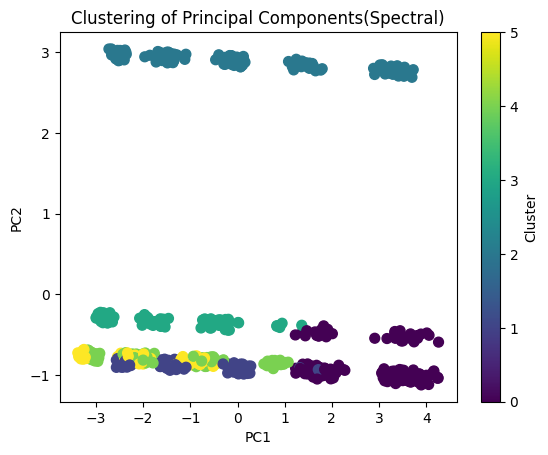

Silhouette score for Spectral Model: 0.4370883282245941
Davies Bouldin Score for Spectral Model: 0.9008838755428347
Calinski Harabasz Score for Spectral Model: 387.912569554157


In [166]:
# Reduce dimensions for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_transformed['Cluster'], cmap='viridis', s=50)
plt.title("Clustering of Principal Components(Spectral)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.savefig('../img/fig-spectral-PCA.png')
plt.show()

# compute scores to evaluate cluster quality
silhouette_avg_sp = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette score for Spectral Model: {silhouette_avg_sp}")

db_index = davies_bouldin_score(X_pca, cluster_labels)
print(f"Davies Bouldin Score for Spectral Model: {db_index}")

ch_index = calinski_harabasz_score(X_pca, cluster_labels)
print(f"Calinski Harabasz Score for Spectral Model: {ch_index}")

___
### Clustering Evaluation
Finally, let's compare our three clustering methods and their respective clusters:
|![K-Means Clusters](../img/fig-k-means-clusters-PCA.png) |![Agglomerative Clusters](../img/fig-agglom-PCA.png) |![Spectral Clusters](../img/fig-spectral-PCA.png) |
|-|-|-|

Here, we've computed the mean values across clusters for each clustering method.

In [168]:
df_km_avg = df_km.groupby('Cluster').mean().assign(Method='K-means')
df_agg_avg = df_agg.groupby('Cluster').mean().assign(Method='Agglomerative')
df_sp_avg = df_sp.groupby('Cluster').mean().assign(Method='Spectral')

results = pd.concat([df_km_avg, df_agg_avg, df_sp_avg])
results.head(18)

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12,Operating System_iOS,Gender_Male,Method
Cluster,,,,,,,,,,,,,
0,157.872093,3.334884,999.174419,33.465116,527.604651,39.767442,0.000000,0.000000,0.000000,1.0,1.0,0.500000,K-means
1,234.720721,4.977477,1521.693694,49.828829,820.261261,38.378378,0.225225,0.189189,0.288288,0.0,0.0,0.423423,K-means
2,543.342857,10.184762,2693.057143,89.009524,1984.771429,38.142857,0.247619,0.219048,0.276190,0.0,0.0,0.571429,K-means
3,94.372807,2.261404,669.864035,22.855263,326.964912,38.114035,0.245614,0.245614,0.254386,0.0,0.0,0.552632,K-means
4,459.966667,8.435000,2435.666667,80.333333,1593.166667,37.800000,0.000000,0.000000,0.000000,1.0,1.0,0.483333,K-means
5,399.936364,6.913636,2101.218182,69.918182,1235.072727,39.045455,0.236364,0.300000,0.245455,0.0,0.0,0.536364,K-means
0,316.954751,5.941176,1810.144796,59.828054,1026.728507,38.710407,0.230769,0.244344,0.266968,0.0,0.0,0.479638,Agglomerative
1,94.372807,2.261404,669.864035,22.855263,326.964912,38.114035,0.245614,0.245614,0.254386,0.0,0.0,0.552632,Agglomerative
2,305.311475,5.837705,1792.098361,59.786885,1015.098361,38.557377,0.000000,0.000000,0.000000,1.0,1.0,0.442623,Agglomerative


Let's also examine the silhouette, Davies Bouldin, and Calinski Harabasz scores for each method in order to assess the quality of each cluster:

- **For K-means clustering**, the silhouette score was **0.687**, the Davies Bouldin score was **0.424**, and the Calinski Harabasz score was **2375.874**
- **For agglomerative hierarchical clustering**, the silhouette score was **0.659**, the Davies Bouldin score was **0.466**, and the Calinski Harabasz score was **387.913**
- **For spectral clustering**, the silhouette score was **0.437**, the Davies Bouldin score was **0.900**, and the Calinski Harabasz score was **387.913**

The silhouette score measures how similar a point is to the points in its own cluster compared to points in other clusters. A higher silhouette score (close to 1) suggests that the clusters are well-separated and each point is assigned to a suitable cluster. The Davies-Bouldin index evaluates how well clusters are separated and how tight they are; a lower value means better separation and more cohesive clusters. The Calinski-Harabasz index, also known as the Variance Ratio Criterion, measures the ratio of between-cluster dispersion to within-cluster dispersion; higher values indicate better-defined clusters.

In this case, k-means produced the best results with a high silhouette score, a low Davies-Bouldin index, and a very high Calinski-Harabasz score, indicating well-separated and cohesive clusters. The agglomerative hierarchical clustering and spectral clustering results, having lower silhouette scores and higher Davies-Bouldin indices, indicate that their clusters overlap more and are not as cleanly defined. Spectral clustering, in particular, shows weaker performance here, which may be due to the nature of the dataset not requiring the type of complex, non-linear cluster boundaries it is best at uncovering.

#### Cluster Characteristics
*Finally, let's take a look at some of the characteristics of the clusters generated by K-means algorithm:*

**Cluster 0:**

- Usage Patterns:
App usage: ~157.87 min/day, Screen on time: ~3.33 hours/day, Battery drain: ~999.17 mAh/day, Data usage: ~527.60 MB/day.

- Demographics:
Average age: 39.77, Gender: 50% male.

- Platform/OS:
Device: Exclusively iPhone 12, OS: 100% iOS.

- Interpretation:
Light app users with moderate engagement. This cluster likely benefits from simple, streamlined features or casual user-focused content.

**Cluster 1:**

- Usage Patterns:
App usage: ~234.72 min/day, Screen on time: ~4.98 hours/day, Battery drain: ~1521.69 mAh/day, Data usage: ~820.26 MB/day.

- Demographics:
Average age: 38.38, Gender: 42.34% male.

- Platform/OS:
Devices: 22.52% OnePlus 9, 18.92% Samsung Galaxy S21, 28.83% Xiaomi Mi 11. No iOS users.

- Interpretation:
Moderate Android users with diverse devices. They might respond well to data-saving features and offers targeting efficient app usage.

**Cluster 2:**

- Usage Patterns:
App usage: ~543.34 min/day, Screen on time: ~10.18 hours/day, Battery drain: ~2693.06 mAh/day, Data usage: ~1984.77 MB/day.

- Demographics:
Average age: 38.14, Gender: 57.14% male.

- Platform/OS:
Devices: 24.76% OnePlus 9, 21.90% Samsung Galaxy S21, 27.62% Xiaomi Mi 11. No iOS users.

- Interpretation:
Heavy Android users with high engagement and resource usage. Ideal for premium features, gaming-related offers, and advanced multitasking tools.

**Cluster 3:**

- Usage Patterns:
App usage: ~94.37 min/day, Screen on time: ~2.26 hours/day, Battery drain: ~669.86 mAh/day, Data usage: ~326.96 MB/day.

- Demographics:
Average age: 38.11, Gender: 55.26% male.

- Platform/OS:
Devices: 24.56% OnePlus 9, 24.56% Samsung Galaxy S21, 25.44% Xiaomi Mi 11. No iOS users.

- Interpretation:
Light Android users with minimal engagement. Educational campaigns and feature discovery might encourage higher usage.

**Cluster 4:**

- Usage Patterns:
App usage: ~459.97 min/day, Screen on time: ~8.44 hours/day, Battery drain: ~2435.67 mAh/day, Data usage: ~1593.17 MB/day.

- Demographics:
Average age: 37.80, Gender: 48.33% male.

- Platform/OS:
Device: Exclusively iPhone 12, OS: 100% iOS.

- Interpretation:
Highly engaged iPhone users with significant usage patterns. Perfect for targeting premium services, ecosystem integrations, and tailored subscriptions.

**Cluster 5:**

- Usage Patterns:
App usage: ~399.94 min/day, Screen on time: ~6.91 hours/day, Battery drain: ~2101.22 mAh/day, Data usage: ~1235.07 MB/day.

- Demographics:
Average age: 39.05, Gender: 53.64% male.

- Platform/OS:
Devices: 23.64% OnePlus 9, 30.00% Samsung Galaxy S21, 24.55% Xiaomi Mi 11. No iOS users.

- Interpretation:
Moderate-to-high Android users with balanced engagement. Offers like productivity tools, multitasking enhancements, or battery-saving features could appeal to this group.

___

## Conclusion
We have successfully used three clustering techniques in order to generate groups of cell phone users with similar usage patterns! We also used various metrics in order to evaluate each clustering. Given the opportunity to revisit this project, we would like to explore different clustering methods such as divisive hierarchical clustering or use clustering in order to perform anomaly detection.